# Model Results Visualization
This notebook is intended to pull model artifacts from the Neptune experiment logger and run it on a few samples from the dataset to see visualize how the different model's are segmenting the data. 

In [42]:
from neptune import Session
import pickle
from rasterio.plot import show
import pytorch_lightning as pl
import torch
import torchvision
import zipfile
from matplotlib import pyplot
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [72]:
image_types = ['full_channel', 'rgb', 'ir', 'hsv', 'hsv_with_ir', 'veg_index']

In [73]:
f = open("image_samples.pkl", "rb")
image_samples = pickle.load(f)

In [19]:
# create session and import my project
sesh = Session.with_default_backend(api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5"
                                "lcHR1bmUuYWkiLCJhcGlfa2V5IjoiOGE5NDI0YTktNmE2ZC00ZWZjLTlkMjAtNjNmMTIwM2Q2ZTQzIn0=")
project = sesh.get_project("maxzvyagin/GIS")

In [20]:
experiments = project.get_experiments()

In [21]:
experiments

[Experiment(GIS-132),
 Experiment(GIS-133),
 Experiment(GIS-134),
 Experiment(GIS-135)]

Using cache found in /Users/mzvyagin/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


<All keys matched successfully>

3
{'image': tensor([[[0.1570, 0.1542, 0.1504,  ..., 0.1514, 0.1514, 0.1514],
         [0.1570, 0.1542, 0.1514,  ..., 0.1514, 0.1514, 0.1523],
         [0.1588, 0.1560, 0.1532,  ..., 0.1514, 0.1514, 0.1523],
         ...,
         [0.1709, 0.1718, 0.1718,  ..., 0.1514, 0.1532, 0.1551],
         [0.1681, 0.1690, 0.1690,  ..., 0.1514, 0.1532, 0.1560],
         [0.1644, 0.1653, 0.1662,  ..., 0.1504, 0.1532, 0.1551]],

        [[0.2069, 0.2043, 0.2003,  ..., 0.2003, 0.2003, 0.2003],
         [0.2083, 0.2043, 0.2003,  ..., 0.2016, 0.2016, 0.2003],
         [0.2096, 0.2056, 0.2003,  ..., 0.2016, 0.2016, 0.2003],
         ...,
         [0.2216, 0.2230, 0.2230,  ..., 0.1963, 0.2003, 0.2043],
         [0.2163, 0.2189, 0.2203,  ..., 0.1963, 0.2016, 0.2043],
         [0.2136, 0.2149, 0.2176,  ..., 0.1949, 0.1989, 0.2029]],

        [[0.2537, 0.2501, 0.2465,  ..., 0.2519, 0.2519, 0.2537],
         [0.2555, 0.2501, 0.2447,  ..., 0.2537, 0.2537, 0.2555],
         [0.2573, 0.2519, 0.2447,  ..., 0.2537

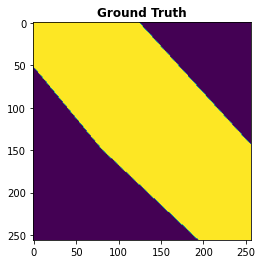

<AxesSubplot:title={'center':'Ground Truth'}>

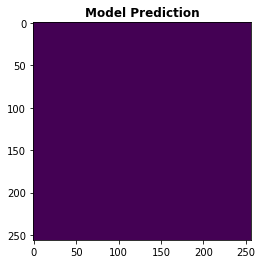

<AxesSubplot:title={'center':'Model Prediction'}>

3
[2000]


TypeError: list indices must be integers or slices, not str

In [75]:
for e in experiments:
    # load in the model
    e.download_artifacts()
    with zipfile.ZipFile('output.zip') as zip_ref:
        zip_ref.extractall()
    f = open('output/latest_model.pkl', 'rb')
    device = torch.device('cpu')
    old_params = torch.load(f, map_location=device)
    params = dict()
    i_type = e.get_parameters()['image_type']
    if i_type == "full_channel":
        input_num = 4
    elif i_type == "rgb":
        input_num = 3
    elif i_type == "ir":
        input_num = 1
    elif i_type == "hsv":
        input_num = 3
    elif i_type == "hsv_with_ir":
        input_num = 4
    elif i_type == "veg_index":
        input_num = 1
    else:
        i_type = 4
    model =  torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=input_num,
                                    out_channels=1,
                                    init_features=32, pretrained=False)
    # fix the weird state dict key error
    for k in old_params.keys():
        new_key = k.split("model.")[1]
        params[new_key] = old_params[k]
    model.load_state_dict(params)
    f.close()
    # check the image type, and get image samples for corresponding image type
    
    # run the model on each of the samples and show results
    # print experiment id, name, image type, and training/test loss
    #print(e.get_properties(), e.get_numeric_channels_values())
    # show mask, and then show the results from each 
    for test in image_samples[i_type]:
        print(len(image_samples[i_type]))
        #fig, (m_axis, i_axis) = pyplot.subplots(1, 2, figsize=(15, 15))
        res = model(test['image'].unsqueeze(0))
        res = res.detach().numpy().astype(int)
        show(test['mask'], title="Ground Truth")
        show(res, title="Model Prediction")
    break